Demo - Poisson equation 2D
=======================

Solve Poisson's equation in 2D with homogeneous Dirichlet bcs in one direction and periodicity in the other.

$$    
\begin{align}
\nabla^2 u(x, y) &= f(x, y), \quad \forall \, (x, y) \in [-1, 1] \times [0, 2\pi]\\
u(\pm 1, y) &= 0 \\
u(x, 2\pi) &= u(x, 0)
\end{align}
$$

where $u(x, y)$ is the solution and $f(x, y)$ is some right hand side function.

Use either Chebyshev basis $P=\{T_k(x)\}_{k=0}^{N_0-1}$ or Legendre $P=\{L_k(x)\}_{k=0}^{N_0-1}$ and define Shen's composite Dirichlet basis as

$$
V^{N_0}(x) = \{P_k(x) - P_{k+2}(x)\, | \, k=0, 1, \ldots, N_0-3\}.
$$

For the periodic direction use Fourier exponentials

$$
V^{N_1}(y) = \{\exp(i l y)\, | \, l=-N_1/2, -N_1/2+1, \ldots, N_1/2-1\}.
$$

And then define tensor product space as an outer product of these spaces

$$
V^N(x, y) = V^{N_0}(x) \times V^{N_1}(y).
$$

We get the test function

$$
\phi_{kl}(x, y) = (P_k(x) - P_{k+2}(x))\exp(i l y),
$$

and define for simplicity

$$
\begin{align}
v(x, y) &= \phi_{kl}(x, y), \\
u(x, y) &= \sum_{k=0}^{N_0-3}\sum_{l=-N_1/2}^{N_1/2-1} \hat{u}_{kl} \phi_{kl}(x, y),
\end{align}
$$

where $u(x, y)$ is the trial function.

The weighted inner product is defined almost exactly like in 1D, however, we now have to take into account that the solution is complex valued. The inner product is now 

$$
(u, v)_w = \int_{-1}^{1}\int_{0}^{2\pi} u v^* w dxdy,
$$

where $v^*$ is the complex conjugate of $v$. Furthermore, we use the constant weight $w(x, y)=1/(2\pi)$ for Legendre/Fourier and get

Find $u \in V^N$ such that

$$     (\nabla u, \nabla v)_w = -(f, v)_w, \quad \forall \, v \in V^N.$$

For Chebyshev the weight is $1/\sqrt{1-x^2}/(2\pi)$ and we do not perform integration by parts: 

Find $u \in V^N$ such that

$$     (\nabla^2 u, v)_w = (f, v)_w, \quad \forall \, v \in V^N.$$

## Implementation using shenfun

In [1]:
from shenfun import *
import matplotlib.pyplot as plt

N = (16, 12)
BX = Basis(N[0], 'L', bc=(0, 0))
BY = Basis(N[1], 'F')
V = TensorProductSpace(comm, (BX, BY))

In [2]:
v = TestFunction(V)
u = TrialFunction(V)
A = inner(grad(u), grad(v))

In [3]:
print(A)

[<shenfun.matrixbase.TPMatrix object at 0x10ff4ce80>, <shenfun.matrixbase.TPMatrix object at 0x10ff4ce10>]


`TPMatrix` is a tensor product matrix. It is the outer product of two smaller matrices. Consider the inner product:

$$
\begin{align}
(\nabla u, \nabla v) &= \frac{1}{2\pi}\int_{-1}^{1}\int_{0}^{2\pi} \left(\frac{\partial u}{\partial x}, \frac{\partial u}{\partial y}\right) \cdot \left(\frac{\partial v^*}{\partial x}, \frac{\partial v^*}{\partial y}\right) {dxdy} \\
(\nabla u, \nabla v) &= \frac{1}{2\pi} \int_{-1}^1 \int_{0}^{2\pi} \left( \frac{\partial u}{\partial x}\frac{\partial v^*}{\partial x} + \frac{\partial u}{\partial y}\frac{\partial v^*}{\partial y} \right) {dxdy} \\
(\nabla u, \nabla v) &= \frac{1}{2\pi}\int_{-1}^1 \int_{0}^{2\pi} \frac{\partial u}{\partial x}\frac{\partial v^*}{\partial x} {dxdy} + \int_{-1}^1 \int_{0}^{2\pi} \frac{\partial u}{\partial y}\frac{\partial v^*}{\partial y} {dxdy}
\end{align}
$$

which is also a sum of two terms. These two terms are the two `TPMatrix`es returned by `inner` above.

Now each one of these two terms can be written as the outer product of two smaller matrices. Consider the first:

$$
\begin{align}
\frac{1}{2\pi}\int_{-1}^1 \int_{0}^{2\pi} \frac{\partial u}{\partial x}\frac{\partial v^*}{\partial x} {dxdy} &= \frac{1}{2\pi}\int_{-1}^1 \int_{0}^{2\pi} \frac{\partial \sum_{m}\sum_{n} \hat{u}_{mn} \phi_{mn}}{\partial x}\frac{\partial \phi_{kl}^*}{\partial x }{dxdy} \\
   &= \sum_{m}\sum_{n} \hat{u}_{mn} \frac{1}{2\pi} \int_{-1}^1 \int_{0}^{2\pi} \frac{\partial (P_m(x)-P_{m+2}(x))\exp(iny)}{\partial x}\frac{\partial (P_k(x)-P_{k+2}(x))\exp(-ily)}{\partial x} {dxdy} \\
   &= \sum_{m}\sum_{n} \hat{u}_{mn} \frac{1}{2\pi} \int_{-1}^1 \int_{0}^{2\pi} \frac{\partial (P_m(x)-P_{m+2}(x))}{\partial x}\frac{\partial (P_k(x)-P_{k+2}(x))}{\partial x} \exp(iny) \exp(-ily) {dxdy} \\
   &= \sum_{m}\sum_{n} \hat{u}_{mn} \underbrace{\int_{-1}^1 \frac{\partial (P_m(x)-P_{m+2}(x))}{\partial x}\frac{\partial (P_k(x)-P_{k+2}(x))}{\partial x} {dx}}_{a_{km}} \underbrace{\frac{1}{2\pi}\int_{0}^{2\pi}  \exp(iny) \exp(-ily) {dy}}_{\delta_{ln}} \\
   &= a_{km} \delta_{ln} \hat{u}_{mn} \\
   &= a_{km} \hat{u}_{ml}
\end{align}
$$

In [4]:
print(A[0].mats)

[{0: array([ 6., 10., 14., 18., 22., 26., 30., 34., 38., 42., 46., 50., 54.,
       58.])}, {0: 1}]


The first item of the `A[0].mats` list is the $a_{km}$ matrix and the second is the identity matrix.

Now create a manufactured solution to test the implementation.

In [5]:
import sympy as sp
x, y = sp.symbols('x,y')
ue = (sp.cos(4*x) + sp.sin(2*y))*(1 - x**2)
fe = ue.diff(x, 2) + ue.diff(y, 2)
fl = sp.lambdify((x, y), fe, 'numpy')
fj = Array(V, buffer=fl(*V.mesh()))

Assemble right hand side

In [6]:
f_tilde = Function(V)
f_tilde = inner(v, -fj, output_array=f_tilde)

Solve system of equations by fetching an efficient Helmholtz solver

In [7]:
u_hat = Function(V)
solver = legendre.la.Helmholtz(*A)
u_hat = solver(u_hat, f_tilde)

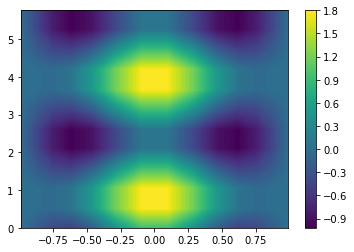

In [8]:
X = V.local_mesh(True)
plt.contourf(X[0], X[1], u_hat.backward(), 100)
plt.colorbar()